In [1]:
!nvidia-smi

Thu Apr 20 19:54:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 45%   31C    P8    N/A /  75W |    842MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from wordcloud import WordCloud

from gensim import models
from gensim.models import CoherenceModel
import gensim.corpora as corpora

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Load Dataset

In [3]:
df = pd.read_csv("../dataset/gmaps_review_dataset - labelling - review.csv")

In [4]:
df.head()

,id,PIC,datetime,date status,scrapped_at,location,rating,text,aksesibilitas,fasilitas (akomodasi dan amenitas),aktivitas (atraksi dan aktivitas)
0,47d0cdd937754bd6b860f89b2bab1dbb,Fakhri,2022-05-15 11:58:43,Valid,2023-02-15 11:58:43,Curug Malela,4,Akses jalannya waktu itu masih sulit di jangka...,2,0,0
1,4804acd6c05e4f89b098e2ca35019419,Fakhri,2022-08-15 11:58:43,Valid,2023-02-15 11:58:43,Curug Malela,5,"Perjalanan yg bnr"" bikin Syahduu ,, dr Tempat ...",1,0,1
2,3eae265bf32a45eca31765a4145bc030,Fakhri,2022-03-15 11:58:43,Valid,2023-02-15 11:58:43,Curug Malela,5,"Minggu 13 februari 2022 ,\n\ngas santai pakai ...",1,2,1
3,61037dbdb7b14045be49d4494e95cf05,Fakhri,2022-05-15 11:58:44,Valid,2023-02-15 11:58:44,Curug Malela,5,7 mei 2022\nTouring bari mudik\nMntap perjalan...,1,0,1
4,a2c9e817e2b949c6880f971f43a11d2f,Fakhri,2022-08-15 11:58:44,Valid,2023-02-15 11:58:44,Curug Malela,5,Perjalanan touring motor dari bekasi melewati ...,0,0,1


In [5]:
df = df.rename(columns={'date status':'status'})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13587 entries, 0 to 13586
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   id                                  13587 non-null  object
 1   PIC                                 13587 non-null  object
 2   datetime                            13587 non-null  object
 3   status                              13587 non-null  object
 4   scrapped_at                         13587 non-null  object
 5   location                            13587 non-null  object
 6   rating                              13587 non-null  int64 
 7   text                                13587 non-null  object
 8   aksesibilitas                       13587 non-null  int64 
 9   fasilitas (akomodasi dan amenitas)  13587 non-null  object
 10  aktivitas (atraksi dan aktivitas)   13587 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


In [7]:
df['datetime'] = df['datetime'].apply(pd.to_datetime)

# Preprocessing

## Data Filtering

In [8]:
mask = (df['datetime'] >= '2019-1-1')
df = df.loc[mask]

In [9]:
len(df)

12569

In [10]:
df = df.drop(columns=['PIC', 'scrapped_at', 'rating', 'aksesibilitas', 'fasilitas (akomodasi dan amenitas)', 'aktivitas (atraksi dan aktivitas)'])

In [11]:
df = df[df['location'] != 'Situ Lembang Dano']

In [12]:
df = df[df['status'] != 'Invalid']

In [13]:
df = df.drop_duplicates(subset=['text'])

In [14]:
len(df)

11658

## Data Cleaning

In [15]:
def get_translate_text(text):
    keyword = ['(Diterjemahkan oleh Google)', '(Asli)']
    if keyword[0] in text and keyword[1] in text:
        text = text[text.find(keyword[0]) + len(keyword[0]):text.rfind(keyword[1])]
    elif keyword[0] in text and keyword[1] not in text:
        text = text[text.find(keyword[0]) + len(keyword[0]):]
    return text 

In [16]:
def clean_text(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r' ', text) # no emoji
    text = text.lower() #to lowercase
    text = re.sub('\n', ' ', text) #remove \n
    text = re.sub(r'[^\w\s]', ' ', text) #remove punctuation
    text = re.sub("\d+", "", text) #remove number
    text = re.sub(' +', ' ', text) #remove multiple whitespace
    
    if re.search(r'([a-zA-Z])\1{2,}', text): # Spell
        text = re.sub(r'([a-zA-Z])\1{2,}','\\1', text)
        
    return text

In [17]:
df['text_preprocess'] = df['text'].apply(get_translate_text)
df['text_preprocess'] = df['text_preprocess'].apply(clean_text)
df['len_char'] = df['text_preprocess'].apply(lambda x: len(x))
df['len_word'] = df['text_preprocess'].apply(lambda x: len(x.split(' ')))

In [18]:
df.head()

,id,datetime,status,location,text,text_preprocess,len_char,len_word
0,47d0cdd937754bd6b860f89b2bab1dbb,2022-05-15 11:58:43,Valid,Curug Malela,Akses jalannya waktu itu masih sulit di jangka...,akses jalannya waktu itu masih sulit di jangka...,84,13
1,4804acd6c05e4f89b098e2ca35019419,2022-08-15 11:58:43,Valid,Curug Malela,"Perjalanan yg bnr"" bikin Syahduu ,, dr Tempat ...",perjalanan yg bnr bikin syahduu dr tempat park...,110,19
2,3eae265bf32a45eca31765a4145bc030,2022-03-15 11:58:43,Valid,Curug Malela,"Minggu 13 februari 2022 ,\n\ngas santai pakai ...",minggu februari gas santai pakai motor dari da...,1993,338
3,61037dbdb7b14045be49d4494e95cf05,2022-05-15 11:58:44,Valid,Curug Malela,7 mei 2022\nTouring bari mudik\nMntap perjalan...,mei touring bari mudik mntap perjalanan sungg...,162,25
4,a2c9e817e2b949c6880f971f43a11d2f,2022-08-15 11:58:44,Valid,Curug Malela,Perjalanan touring motor dari bekasi melewati ...,perjalanan touring motor dari bekasi melewati ...,152,23


In [19]:
df[df['id'] == '3452054e89614078a257967adbbee4b6']

,id,datetime,status,location,text,text_preprocess,len_char,len_word
8340,3452054e89614078a257967adbbee4b6,2021-02-15 14:13:20,Valid,Sanghyang Kenit,Kerennnn 😍 …,keren,6,2


## Tokenizing

In [20]:
df['tokens'] = df['text_preprocess'].apply(lambda x: word_tokenize(x))

In [21]:
df['tokens']

0        [akses, jalannya, waktu, itu, masih, sulit, di...
1        [perjalanan, yg, bnr, bikin, syahduu, dr, temp...
2        [minggu, februari, gas, santai, pakai, motor, ...
3        [mei, touring, bari, mudik, mntap, perjalanan,...
4        [perjalanan, touring, motor, dari, bekasi, mel...
                               ...                        
13582    [hanya, mencoba, sarapan, dan, offroad, pakai,...
13583    [pngnnya, ksni, petik, strawberry, tpi, lgi, g...
13584    [ksini, cuma, main, aja, dan, lihat, lihat, su...
13585    [luar, biasa, mantap, makan, prasmanan, ny, mu...
13586             [tempat, dan, suasananya, sejuk, banget]
Name: tokens, Length: 11658, dtype: object

stop_words = StopWordRemoverFactory().get_stop_words()## Stopwords removal

In [22]:
stop_words = StopWordRemoverFactory().get_stop_words()
extend_stopword = ['pas', 'yg', 'tp', 'rb', 'km', 'tp', 'dg', 'dr']

stop_words += extend_stopword

df['tokens'] = df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

In [ ]:
# from nltk.corpus import stopwords 

# stop_words = sorted(list(set(stopwords.words('indonesian')) - set(['jauh'])))
# stop_words.extend(['yg', 'rb', 'nya'])

# df['tokens'] = df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

In [23]:
df['tokens']

0        [akses, jalannya, waktu, sulit, jangkau, perja...
1        [perjalanan, bnr, bikin, syahduu, parkir, loka...
2        [minggu, februari, gas, santai, pakai, motor, ...
3        [mei, touring, bari, mudik, mntap, perjalanan,...
4        [perjalanan, touring, motor, bekasi, melewati,...
                               ...                        
13582    [mencoba, sarapan, offroad, pakai, land, rover...
13583    [pngnnya, ksni, petik, strawberry, tpi, lgi, p...
13584    [ksini, main, aja, suasananya, emg, banget, pe...
13585                [mantap, makan, prasmanan, ny, murah]
13586                          [suasananya, sejuk, banget]
Name: tokens, Length: 11658, dtype: object

## Stemming

In [24]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
 
df['tokens'] = df['tokens'].apply(lambda x: stemmer.stem(' '.join(x)).split(' '))

In [25]:
df['tokens']

0        [akses, jalan, waktu, sulit, jangkau, jalan, t...
1        [jalan, bnr, bikin, syahduu, parkir, lokasi, c...
2        [minggu, februari, gas, santai, pakai, motor, ...
3        [mei, touring, bari, mudik, mntap, jalan, sung...
4        [jalan, touring, motor, bekas, lewat, track, s...
                               ...                        
13582    [coba, sarap, offroad, pakai, land, rover, mak...
13583    [pngnnya, ksni, petik, strawberry, tpi, lgi, p...
13584    [ksini, main, aja, suasana, emg, banget, inap,...
13585                [mantap, makan, prasmanan, ny, murah]
13586                             [suasana, sejuk, banget]
Name: tokens, Length: 11658, dtype: object

In [26]:
df.loc[df['id'] == '9d6e15357c5441078e33cf373d9b272d']

,id,datetime,status,location,text,text_preprocess,len_char,len_word,tokens
1049,9d6e15357c5441078e33cf373d9b272d,2020-02-15 12:32:57,Valid,Taman Hutan Jayagiri Lembang,Good place to hiking with friends or family. T...,tempat yang bagus untuk hiking bersama teman ...,108,19,"[bagus, hiking, teman, keluarga, warung, jual,..."


## Additional Step

In [27]:
def reduction_character_less_than_n(text):
    new_text = []
    char_less_than_threshold = 2
    length_word = len(text)
    for word_i in range(length_word):
        if len(text[word_i]) > char_less_than_threshold:
            new_text += [text[word_i]]
    
    return new_text

In [29]:
df['tokens'] = df['tokens'].apply(reduction_character_less_than_n)

In [ ]:
# text = ['jalan', 'lumayan', 'jalur', 'mobil', 'pas', 'pas', 'mobil', 'parkir', 'jalan', 'kaki', 'ojeg', 'km', 'curug', 'tp', 'bayar', 'dg', 'pandang', 'curug', 'indah']
# text_new = reduction_character_less_than_n(text)
# text_new

In [30]:
df = df.drop_duplicates(subset=['text_preprocess'])

In [31]:
len(df)

11567

In [32]:
df['len_token'] = df['tokens'].apply(lambda x: len(x))

In [33]:
df[df['len_token'] <= 3]

,id,datetime,status,location,text,text_preprocess,len_char,len_word,tokens,len_token
49,457feb4e6161474f829dd51b07af05fe,2023-01-15 11:58:46,Valid,Curug Malela,Niagara kecil yang tersembunyi,niagara kecil yang tersembunyi,30,4,"[niagara, sembunyi]",2
79,7f59834407cf4fddaf1df89ad19086df,2021-02-15 11:58:47,Valid,Curug Malela,Kami siap mengantar dengan menggunakan Landrover,kami siap mengantar dengan menggunakan landrover,48,6,"[antar, landrover]",2
80,99b21520cfe74ac5a7bf488dbd835994,2022-12-15 11:58:47,Valid,Curug Malela,Sangat bermakna alam kita,sangat bermakna alam kita,25,4,"[makna, alam]",2
86,9633aebda8c14ee5a9221c3f614ccc94,2021-02-15 11:58:48,Valid,Curug Malela,Rasa capenya bisa tergantikan🖤 …,rasa capenya bisa tergantikan,30,5,"[cape, ganti]",2
91,bbbe2c7a216a498ab399a5ce2aba4213,2022-09-15 11:58:48,Valid,Curug Malela,Mulai banyak renov saya suka,mulai banyak renov saya suka,28,5,"[renov, suka]",2
...,...,...,...,...,...,...,...,...,...,...
13534,d69e47e004374677a615196ae2f57ccf,2022-02-23 18:23:22,Valid,Terminal Wisata Grafika Cikole,"Sejuk,nyaman, makanan enak2",sejuk nyaman makanan enak,25,4,"[sejuk, nyaman, makan]",3
13554,57d9d3c198284feda8adf766745fc86c,2022-12-23 18:23:25,Valid,Terminal Wisata Grafika Cikole,Pilihan tepat untuk liburan 👍👍👍 …,pilihan tepat untuk liburan,28,5,"[pilih, libur]",2
13561,551121bcddf94895b3e91ad898fe5cb8,2020-02-23 18:23:26,Valid,Terminal Wisata Grafika Cikole,Mantaaapppp lah tempatnya,mantap lah tempatnya,20,3,"[mantap, tempat]",2
13571,c229fba45de2445d910bad68c03b8ada,2021-02-23 18:23:27,Valid,Terminal Wisata Grafika Cikole,Nyaman tuk bersantai,nyaman tuk bersantai,20,3,"[nyaman, tuk, santa]",3


In [34]:
df = df[df['len_token'] >= 2]
df = df[df['len_token'] < 300]

In [35]:
len(df)

11229

In [37]:
df.to_excel('../dataset/dataset_preprocess.xlsx')

# Explanatory Data Analysis

In [38]:
df['location'].value_counts()

Gunung Tangkuban Parahu           924
Curug Maribaya                    914
Floating Market Lembang           910
Stone Garden                      906
Gunung Putri Lembang              905
Sarae Hills                       898
Terminal Wisata Grafika Cikole    897
Orchid Forest Cikole              672
Curug Tilu Leuwi Opat             595
Taman Lembah DEWATA               505
Ciwangun Indah Camp (CIC)         443
Sanghyang Heuleut                 399
Curug Cimahi / Curug Pelangi      379
Kebun Begonia Lembang             359
Curug Layung Camp Situ Lembang    302
Sanghyang Kenit                   298
Bukit Senyum                      261
Curug Malela                      159
Taman Hutan Jayagiri Lembang      136
Curug Sawer Cililin               135
Situ Ciburuy                      105
Curug Halimun                      54
Curug Panganten                    43
Gunung Hawu                        27
Sirtwo Island Saguling              3
Name: location, dtype: int64

C:\Users\Fakhri\anaconda3\envs\aidev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='len_word'>

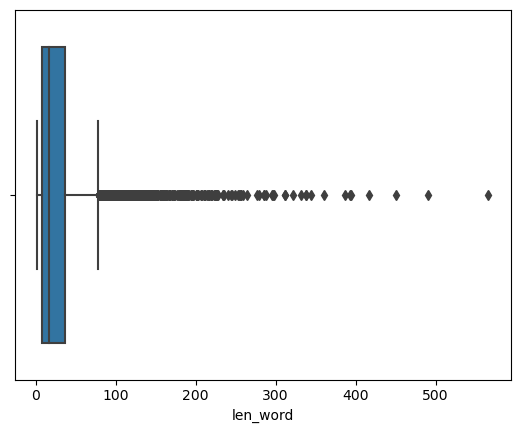

In [39]:
sns.boxplot(df['len_word'])

In [40]:
df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

In [41]:
df['tokens'].values

array(['akses jalan waktu sulit jangkau jalan tuji curug lumayan',
       'jalan bnr bikin syahduu parkir lokasi curug lelahh hilang sampe lokasi',
       'minggu februari gas santai pakai motor dago jam sampe parkir curug jam disasarin gps gunung halu percaya gps sasarin ikut tunjuk jalan warga jalan cililin bagus jalan cor proyek jalan blom beres bolong tengah jalan ati aja oke tiket motor tiket parkir motor tagih pulang harga makan parkir nasi ayam sayur kacang gpp larisin guys kasi jual sana sepi oke star jalan kaki parkir full trek turun berat nih pulang jalan santai nikmat view jalan lumayan kudu ati ambil video curug menit jalan warung buka sayang sepi beli waktu kesana turun pasang sepi curugnya bagus indah liat foto jalan bersih sampah kesana bapa tugas beres lapin duduk sasapu baguss sayang jembatan foto kayu bolong licin ciprat air lapuk kudu akalin tuh cari bahan kuat air pokok kudu hati pis rawan jatoh oke nanjak dikit ketemu ojek situ diskus istri jalan ojek aja debat oje

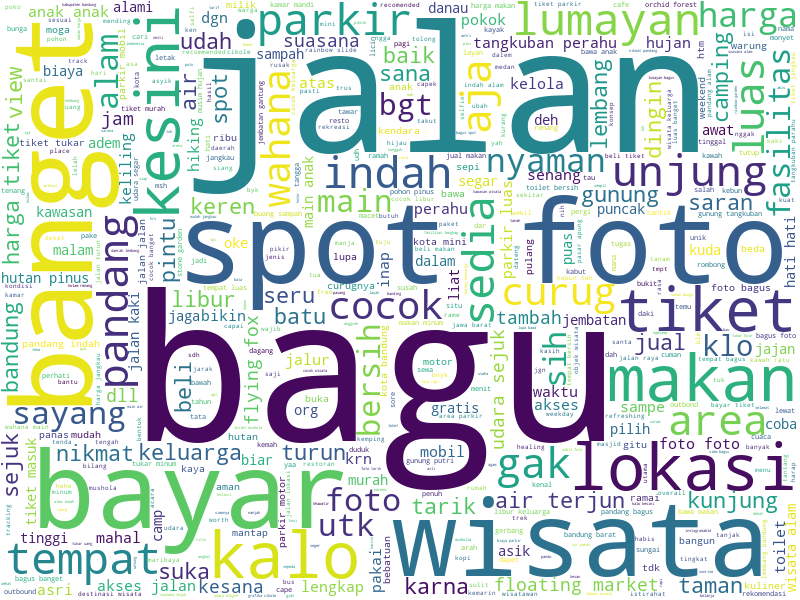

In [42]:
long_string = ''.join(df['tokens'].values)
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, 
                      contour_color='steelblue', width=800, height=600)
wordcloud.generate(long_string)

wordcloud.to_image()

# Convert to corpus

In [43]:
df['tokens'] = df['tokens'].apply(lambda x: word_tokenize(x))

In [44]:
id2word = corpora.Dictionary(df['tokens'])
texts = df['tokens']
corpus = [id2word.doc2bow(text) for text in texts]

In [45]:
corpus[1]

[(1, 1),
 (2, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 1),
 (14, 1),
 (15, 1)]

In [46]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [47]:
corpus_tfidf[1]

[(1, 0.1686499340498302),
 (2, 0.09843670808846382),
 (8, 0.21690991608238414),
 (9, 0.4527564639418333),
 (10, 0.2720744482382014),
 (11, 0.47506868083264214),
 (12, 0.2832860434902702),
 (13, 0.11967473533496387),
 (14, 0.22837488829081884),
 (15, 0.5132116675425625)]

# Apply Model

In [48]:
import gensim
from pprint import pprint

num_topics = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,
                                       id2word=id2word,
                                       num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"bagus" + 0.007*"foto" + 0.007*"jalan" + 0.006*"pandang" + '
  '0.006*"air" + 0.005*"banget" + 0.005*"indah" + 0.005*"suasana" + '
  '0.005*"tempat" + 0.005*"wisata"'),
 (1,
  '0.011*"tempat" + 0.010*"bagus" + 0.010*"indah" + 0.009*"sejuk" + '
  '0.009*"pandang" + 0.007*"banget" + 0.006*"jalan" + 0.006*"keluarga" + '
  '0.006*"asri" + 0.006*"bersih"'),
 (2,
  '0.007*"nyaman" + 0.007*"bagus" + 0.006*"air" + 0.006*"foto" + '
  '0.005*"keluarga" + 0.005*"sejuk" + 0.005*"spot" + 0.005*"inap" + '
  '0.005*"makan" + 0.005*"lumayan"'),
 (3,
  '0.007*"wisata" + 0.007*"lumayan" + 0.007*"indah" + 0.006*"bagus" + '
  '0.006*"bersih" + 0.006*"sejuk" + 0.006*"jalan" + 0.005*"alam" + '
  '0.005*"anak" + 0.005*"nyaman"'),
 (4,
  '0.008*"foto" + 0.007*"bagus" + 0.006*"wisata" + 0.006*"tiket" + '
  '0.005*"spot" + 0.005*"jalan" + 0.005*"anak" + 0.005*"parkir" + 0.004*"luas" '
  '+ 0.004*"tempat"'),
 (5,
  '0.011*"bagus" + 0.008*"cocok" + 0.008*"keluarga" + 0.007*"tempat" + '
  '0.007*"fot

# Evaluate

In [53]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [54]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus_tfidf, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\Fakhri\AppData\Local\Temp\ipykernel_5568\1674161953.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Fakhri\AppData\Local\Temp\ipykernel_5568\1674161953.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.7450,"bagus, indah, wisata, pandang, tempat, foto, j...","[akses, jalan, waktu, sulit, jangkau, jalan, t..."
1,1,8.0,0.7645,"alami, tempat, bagus, dingin, banget, sejuk, w...","[jalan, bnr, bikin, syahduu, parkir, lokasi, c..."
2,2,3.0,0.7796,"wisata, lumayan, indah, bagus, bersih, sejuk, ...","[minggu, februari, gas, santai, pakai, motor, ..."
3,3,2.0,0.8152,"nyaman, bagus, air, foto, keluarga, sejuk, spo...","[mei, touring, bari, mudik, mntap, jalan, sung..."
4,4,1.0,0.7923,"tempat, bagus, indah, sejuk, pandang, banget, ...","[jalan, touring, motor, bekas, lewat, track, s..."
5,5,1.0,0.7356,"tempat, bagus, indah, sejuk, pandang, banget, ...","[nyampe, lnjut, bawah, jam, mantap, suasana, s..."
6,6,0.0,0.8178,"bagus, foto, jalan, pandang, air, banget, inda...","[indah, air, keruh, musim, hujan, juang, hilan..."
7,7,5.0,0.4441,"bagus, cocok, keluarga, tempat, foto, pandang,...","[jalan, lumayan, lelah, muas, sampe, lokasi, w..."
8,8,8.0,0.8201,"alami, tempat, bagus, dingin, banget, sejuk, w...","[visit, here, lokasi, bandung, barat, curugnya..."
9,9,9.0,0.8157,"bagus, cocok, anak, nyaman, keluarga, camping,...","[tiket, org, parkir, mobil, akses, jalan, kecu..."


In [49]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.41449077451248745


In [50]:
for index, score in sorted(lda_model[corpus_tfidf[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.7449759840965271	 
Topic: 0.008*"bagus" + 0.007*"indah" + 0.005*"wisata" + 0.005*"pandang" + 0.005*"tempat" + 0.005*"foto" + 0.005*"jalan" + 0.004*"murah" + 0.004*"bayar" + 0.004*"nyaman"

Score: 0.028337499126791954	 
Topic: 0.007*"wisata" + 0.007*"lumayan" + 0.007*"indah" + 0.006*"bagus" + 0.006*"bersih" + 0.006*"sejuk" + 0.006*"jalan" + 0.005*"alam" + 0.005*"anak" + 0.005*"nyaman"

Score: 0.028336355462670326	 
Topic: 0.007*"alami" + 0.007*"tempat" + 0.006*"bagus" + 0.006*"dingin" + 0.006*"banget" + 0.006*"sejuk" + 0.006*"wisata" + 0.005*"udara" + 0.005*"air" + 0.005*"keren"

Score: 0.028336256742477417	 
Topic: 0.011*"tempat" + 0.010*"bagus" + 0.010*"indah" + 0.009*"sejuk" + 0.009*"pandang" + 0.007*"banget" + 0.006*"jalan" + 0.006*"keluarga" + 0.006*"asri" + 0.006*"bersih"

Score: 0.02833624742925167	 
Topic: 0.009*"bagus" + 0.006*"segar" + 0.006*"jalan" + 0.006*"foto" + 0.006*"pandang" + 0.006*"udara" + 0.005*"asik" + 0.005*"keren" + 0.005*"wisata" + 0.005*"cocok"

Score

In [51]:
df.head()

,id,datetime,status,location,text,text_preprocess,len_char,len_word,tokens,len_token
0,47d0cdd937754bd6b860f89b2bab1dbb,2022-05-15 11:58:43,Valid,Curug Malela,Akses jalannya waktu itu masih sulit di jangka...,akses jalannya waktu itu masih sulit di jangka...,84,13,"[akses, jalan, waktu, sulit, jangkau, jalan, t...",9
1,4804acd6c05e4f89b098e2ca35019419,2022-08-15 11:58:43,Valid,Curug Malela,"Perjalanan yg bnr"" bikin Syahduu ,, dr Tempat ...",perjalanan yg bnr bikin syahduu dr tempat park...,110,19,"[jalan, bnr, bikin, syahduu, parkir, lokasi, c...",11
2,3eae265bf32a45eca31765a4145bc030,2022-03-15 11:58:43,Valid,Curug Malela,"Minggu 13 februari 2022 ,\n\ngas santai pakai ...",minggu februari gas santai pakai motor dari da...,1993,338,"[minggu, februari, gas, santai, pakai, motor, ...",185
3,61037dbdb7b14045be49d4494e95cf05,2022-05-15 11:58:44,Valid,Curug Malela,7 mei 2022\nTouring bari mudik\nMntap perjalan...,mei touring bari mudik mntap perjalanan sungg...,162,25,"[mei, touring, bari, mudik, mntap, jalan, sung...",18
4,a2c9e817e2b949c6880f971f43a11d2f,2022-08-15 11:58:44,Valid,Curug Malela,Perjalanan touring motor dari bekasi melewati ...,perjalanan touring motor dari bekasi melewati ...,152,23,"[jalan, touring, motor, bekas, lewat, track, s...",14


In [ ]:
# df.to_excel("../dataset/dataset_preprocess.xlsx", index=False)

# Result

In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared